# Empty droplet analysis

Jupyter notebook containing code for analyzing barcode contamination in cell debris and empty droplets.

Input files required include:
1. Raw count matrices for each paired cell and nuc dataset
2. A list of cells passing all transcriptome QC filters
3. Rabies barcode count matrices for paired cell and nuc datasets

Output files include:
1) Plots related to barcode capture in empty droplets vs. cells/nuclei passing transcriptome filtering

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [25]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
import os
import math
import scanpy as sc
from scipy.stats import ranksums

In [26]:
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/')

## Import data

Get rabies count matrices from paired cell and nuc datasets

In [27]:
#Rabies
c1=pd.read_table('./barcode_count_matrices/c1_completecounts.tsv',delimiter='\t')
c1['datasetid']='c1'
c1['CBC'] = c1['CBC'].str.replace("'", "")
c1['CBC'] = c1['CBC'].str.replace('b', 'c1_')
c1['barcode'] = 'c1_' + c1['barcode']

c2=pd.read_table('./barcode_count_matrices/c2_completecounts.tsv',delimiter='\t')
c2['datasetid']='c2'
c2['CBC'] = c2['CBC'].str.replace("'", "")
c2['CBC'] = c2['CBC'].str.replace('b', 'c2_')
c2['barcode'] = 'c2_' + c2['barcode']

n1=pd.read_table('./barcode_count_matrices/n1_completecounts.tsv',delimiter='\t')
n1['datasetid']='n1'
n1['CBC'] = n1['CBC'].str.replace("'", "")
n1['CBC'] = n1['CBC'].str.replace('b', 'n1_')
n1['barcode'] = 'n1_' + n1['barcode']

n2=pd.read_table('./barcode_count_matrices/n2_completecounts.tsv',delimiter='\t')
n2['datasetid']='n2'
n2['CBC'] = n2['CBC'].str.replace("'", "")
n2['CBC'] = n2['CBC'].str.replace('b', 'n2_')
n2['barcode'] = 'n2_' + n2['barcode']

c3=pd.read_table('./barcode_count_matrices/c3_completecounts.tsv',delimiter='\t')
c3['datasetid']='c3'
c3['CBC'] = c3['CBC'].str.replace("'", "")
c3['CBC'] = c3['CBC'].str.replace('b', 'c3_')
c3['barcode'] = 'c3_' + c3['barcode']

c4=pd.read_table('./barcode_count_matrices/c4_completecounts.tsv',delimiter='\t')
c4['datasetid']='c4'
c4['CBC'] = c4['CBC'].str.replace("'", "")
c4['CBC'] = c4['CBC'].str.replace('b', 'c4_')
c4['barcode'] = 'c4_' + c4['barcode']

n3=pd.read_table('./barcode_count_matrices/n3_completecounts.tsv',delimiter='\t')
n3['datasetid']='n3'
n3['CBC'] = n3['CBC'].str.replace("'", "")
n3['CBC'] = n3['CBC'].str.replace('b', 'n3_')
n3['barcode'] = 'n3_' + n3['barcode']

n4=pd.read_table('./barcode_count_matrices/n4_completecounts.tsv',delimiter='\t')
n4['datasetid']='n4'
n4['CBC'] = n4['CBC'].str.replace("'", "")
n4['CBC'] = n4['CBC'].str.replace('b', 'n4_')
n4['barcode'] = 'n4_' + n4['barcode']

#Final barcode matrices across all experiments are concatenated into one large dataframe
barcodes_df=pd.concat([c1,c2,c3,c4,n1,n2,n3,n4], ignore_index=True, axis=0)
barcodes_df

,CBC,barcode,UMI_Count,datasetid
0,c1_ATCTATTGCATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,6,c1
1,c1_AGGGAGTCAAGGCCTG,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
2,c1_ACCTCATACCTTCATA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
3,c1_CATAATTGCATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
4,c1_CACCAGAAACCAACAG,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
...,...,...,...,...
29564918,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564919,n4_CCTCAATGACCACAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564920,n4_AAGGAGGGAGCAACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564921,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


Import raw sparse matrices and pull list of empty droplets (≤10 UMIs)

In [28]:
def pull_empty_droplets(matrix_path, #path to raw matrix directory
                        umis #max number of UMIs empty droplets are allowed to have
                       ):
    temp=sc.read_10x_mtx(matrix_path)
    sc.pp.filter_cells(temp, max_counts=umis)
    print('Total number of empty droplets')
    print(temp.n_obs)
    empty=sc.get.obs_df(temp)

    return empty

In [29]:
c1_empty=pull_empty_droplets('./transcriptome/raw_matrices/c1/',10)
c2_empty=pull_empty_droplets('./transcriptome/raw_matrices/c2/',10)
c3_empty=pull_empty_droplets('./transcriptome/raw_matrices/c3/',10)
c4_empty=pull_empty_droplets('./transcriptome/raw_matrices/c4/',10)

n1_empty=pull_empty_droplets('./transcriptome/raw_matrices/n1/',10)
n2_empty=pull_empty_droplets('./transcriptome/raw_matrices/n2/',10)
n3_empty=pull_empty_droplets('./transcriptome/raw_matrices/n3/',10)
n4_empty=pull_empty_droplets('./transcriptome/raw_matrices/n4/',10)

Total number of empty droplets
899503
Total number of empty droplets
1792509
Total number of empty droplets
906022
Total number of empty droplets
754118
Total number of empty droplets
1897264
Total number of empty droplets
2077831
Total number of empty droplets
933284
Total number of empty droplets
713258


Import list of filtered cell IDs

In [30]:
filtered_assignments=pd.read_table('./transcriptome/filtered_assignments.csv',delimiter=',')
filtered_assignments = filtered_assignments[filtered_assignments.celltype != 'Unknown']
filtered_assignments

,Unnamed: 0,cellbarcode,celltype,datasetid
0,0,s1_AAAAAAGGCCTCATCA,EN-Newborn,s1
1,1,s1_AAAAAATGAGATAGTT,EN-Newborn,s1
2,2,s1_AAAAAGCGATTGAGCA,EN-Newborn,s1
3,3,s1_AAAAAGTGAGAGACGC,EN-Newborn,s1
4,4,s1_AAAACCAGAGGTATTA,IPC-EN,s1
...,...,...,...,...
46824,46824,u2_CCTTCCGTCCCTAAAT,EN-L2_3-IT,u2
46825,46825,u2_CCTTCCTACATACCAT,EN-L2_3-IT,u2
46826,46826,u2_CCTTCCTCAACCAAAG,EN-L2_3-IT,u2
46827,46827,u2_CCTTCCTCCCATACCA,RG-oRG,u2


## Empty droplet analysis

### Pull barcode counts for real cells/nuc and empty droplets

In [31]:
#Real cells/nuc
real_bcs=barcodes_df.loc[barcodes_df['CBC'].isin(filtered_assignments['cellbarcode'])]
real_bcs

,CBC,barcode,UMI_Count,datasetid
31,c1_AATCCAATAGCGCCGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
106,c1_ATGTCAGAACGGATTG,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,1,c1
108,c1_CCTGCACTACTAAGTG,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,1,c1
117,c1_ACGCACAGCCAACACG,c1_AATTCAAACCCCTGGCGATGG-GATCACCGAGTCAGGTTCAG-...,1,c1
124,c1_CAGCATCAAGGACCAA,c1_AATTCAAACCCCTGGCGATGG-GATCACCGTGCAACCCGGAG-...,1,c1
...,...,...,...,...
29564630,n4_CAGGACCGAGTACAAG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564730,n4_AAAGATTACCCGCAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564782,n4_AGAACAAGAATAAAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564838,n4_AATACAAGAACTACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4


In [32]:
#Empty droplets
c1_empty['datasetid']='c1'
c1_empty['CBC'] = c1_empty.index
c1_empty['CBC'] = 'c1_' + c1_empty['CBC'].astype(str)

c2_empty['datasetid']='c2'
c2_empty['CBC'] = c2_empty.index
c2_empty['CBC'] = 'c2_' + c2_empty['CBC'].astype(str)

c3_empty['datasetid']='c3'
c3_empty['CBC'] = c3_empty.index
c3_empty['CBC'] = 'c3_' + c3_empty['CBC'].astype(str)

c4_empty['datasetid']='c4'
c4_empty['CBC'] = c4_empty.index
c4_empty['CBC'] = 'c4_' + c4_empty['CBC'].astype(str)

n1_empty['datasetid']='n1'
n1_empty['CBC'] = n1_empty.index
n1_empty['CBC'] = 'n1_' + n1_empty['CBC'].astype(str)

n2_empty['datasetid']='n2'
n2_empty['CBC'] = n2_empty.index
n2_empty['CBC'] = 'n2_' + n2_empty['CBC'].astype(str)

n3_empty['datasetid']='n3'
n3_empty['CBC'] = n3_empty.index
n3_empty['CBC'] = 'n3_' + n3_empty['CBC'].astype(str)

n4_empty['datasetid']='n4'
n4_empty['CBC'] = n4_empty.index
n4_empty['CBC'] = 'n4_' + n4_empty['CBC'].astype(str)

empty_droplets=pd.concat([c1_empty,c2_empty,c3_empty,c4_empty,n1_empty,n2_empty,n3_empty,n4_empty])
empty_droplets

,datasetid,CBC
AAAAAAAAAAATAAGT,c1,c1_AAAAAAAAAAATAAGT
AAAAAAAAAAATACAA,c1,c1_AAAAAAAAAAATACAA
AAAAAAAAAAATATTG,c1,c1_AAAAAAAAAAATATTG
AAAAAAAAAACAACGA,c1,c1_AAAAAAAAAACAACGA
AAAAAAAAAACTACCA,c1,c1_AAAAAAAAAACTACCA
...,...,...
CCTTCCTTCCAAATCA,n4,n4_CCTTCCTTCCAAATCA
CCTTCCTTCCATATCC,n4,n4_CCTTCCTTCCATATCC
CCTTCCTTCCGGACAA,n4,n4_CCTTCCTTCCGGACAA
CCTTCCTTCCGTAATA,n4,n4_CCTTCCTTCCGTAATA


In [33]:
empty_cell_barcodes=empty_droplets[empty_droplets['datasetid'].isin(['c1','c2','c3','c4'])]
empty_nuc_barcodes=empty_droplets[empty_droplets['datasetid'].isin(['n1','n2','n3','n4'])]

print(len(empty_cell_barcodes))
print(len(empty_nuc_barcodes))

4352152
5621637


In [34]:
empty_bcs=barcodes_df.loc[barcodes_df['CBC'].isin(empty_droplets['CBC'])]
empty_bcs

,CBC,barcode,UMI_Count,datasetid
43,c1_ATCTCAAACATCAGGA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
76,c1_ACCTAAGTCCTTCATA,c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,c1
94,c1_CCATCCGGAGGGAACG,c1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,c1
107,c1_AACTATGCAGTAAATA,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,5,c1
111,c1_ATAGCAATATAGCATG,c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...,1,c1
...,...,...,...,...
29564783,n4_ACAGAATCCATTCAAC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564908,n4_ACAGAGATACATCAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564918,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564921,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


In [9]:
#Export empty droplet barcodes
empty_bcs.to_csv('./connectivity/empty_droplet_bcs.csv')

### Visualization

Each graph is plotted with real vs. empty cells/nuc, and subdivided into pooled cell and nuc datasets

In [35]:
#Splitting into cell and nuc:
cell_empty=empty_bcs.loc[empty_bcs['datasetid'].isin(['c1','c2','c3','c4'])]
nuc_empty=empty_bcs.loc[empty_bcs['datasetid'].isin(['n1','n2','n3','n4'])]

cell_real=real_bcs.loc[real_bcs['datasetid'].isin(['c1','c2','c3','c4'])]
nuc_real=real_bcs.loc[real_bcs['datasetid'].isin(['n1','n2','n3','n4'])]

##### Transcripts per cell:barcode combination

In [36]:
nuc_dist = nuc_real['UMI_Count']
cell_dist = cell_real['UMI_Count']
empty_c_dist=cell_empty['UMI_Count']
empty_n_dist=nuc_empty['UMI_Count']

print('Nuc mean:')
print(nuc_dist.mean())
print('Nuc median:')
print(nuc_dist.median())
print('Nuc SEM:')
print(nuc_dist.sem())

print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print(cell_dist.median())
print('Cell SEM:')
print(cell_dist.sem())

print('Nuc, empty droplet mean:')
print(empty_n_dist.mean())
print('Nuc, empty droplet median:')
print(empty_n_dist.median())
print('Nuc, empty droplet SEM:')
print(empty_n_dist.sem())

print('Cell, empty droplet mean:')
print(empty_c_dist.mean())
print('Cell, empty droplet median:')
print(empty_c_dist.median())
print('Cell, empty droplet SEM:')
print(empty_c_dist.sem())

print('Wilcoxon Ranked Sum Results, nuclei:')
print(ranksums(nuc_dist, empty_n_dist))

print('Wilcoxon Ranked Sum Results, cells:')
print(ranksums(cell_dist, empty_c_dist))

Nuc mean:
1.1492179791861492
Nuc median:
1.0
Nuc SEM:
0.004262260594361702
Cell mean:
1.6332833217567875
Cell median:
1.0
Cell SEM:
0.010760311391533186
Nuc, empty droplet mean:
1.1239473855533886
Nuc, empty droplet median:
1.0
Nuc, empty droplet SEM:
0.002868054733786163
Cell, empty droplet mean:
1.3905678688345329
Cell, empty droplet median:
1.0
Cell, empty droplet SEM:
0.0054991195473295795
Wilcoxon Ranked Sum Results, nuclei:
RanksumsResult(statistic=40.8253823262088, pvalue=0.0)
Wilcoxon Ranked Sum Results, cells:
RanksumsResult(statistic=59.19913438548862, pvalue=0.0)


In [45]:
nuc_empty

,CBC,barcode,UMI_Count,datasetid
13768336,n1_ATCTATTGCATCAGGA,n1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...,1,n1
13768607,n1_CCAGACGCAGTCATGT,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,n1
13768669,n1_AGCGCATTACCTAGCA,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,n1
13768685,n1_ATGCCCTAAGGCAATC,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,n1
13768699,n1_AGCAAATCAGGAATCC,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,1,n1
...,...,...,...,...
29564783,n4_ACAGAATCCATTCAAC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564908,n4_ACAGAGATACATCAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564918,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
29564921,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


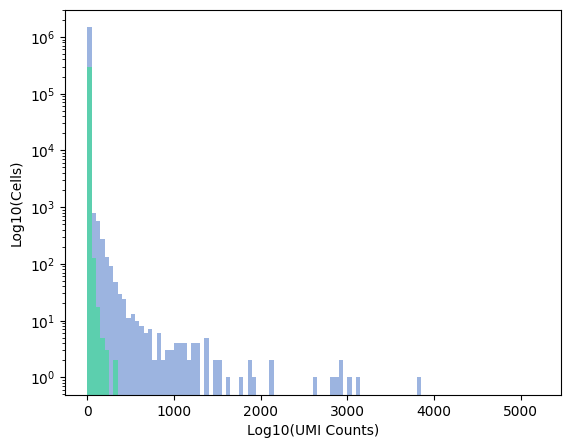

In [38]:
#Cells first
plt.figure().set_figheight(5)

maximum=(cell_real['UMI_Count']).max()
plt.hist((cell_real['UMI_Count']),bins=np.arange(0, maximum + .05, 50),color='#7294d4',alpha=0.7)

maximum=(cell_empty['UMI_Count']).max()
plt.hist((cell_empty['UMI_Count']),bins=np.arange(0, maximum + .05, 50),color='#42DB9A',alpha=0.7)

plt.xlabel('Log10(UMI Counts)')
plt.ylabel('Log10(Cells)')
#plt.xlim([-.1, 4.5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/cell_combo_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

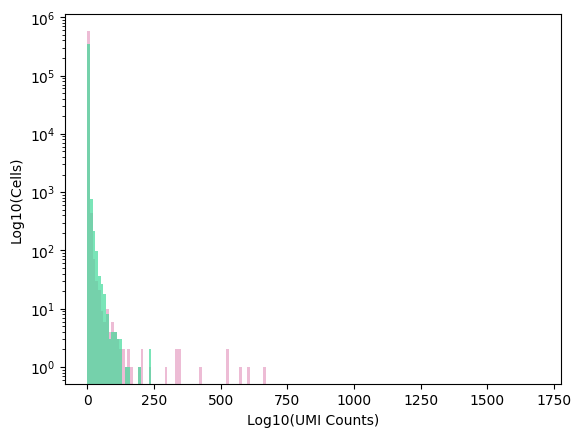

In [49]:
#Then nuc
maximum=(nuc_real['UMI_Count']).max()
plt.hist((nuc_real['UMI_Count']),bins=np.arange(0, maximum + .05, 10),color='#e6a0c4',alpha=0.7)
maximum=(nuc_empty['UMI_Count']).max()
plt.hist((nuc_empty['UMI_Count']),bins=np.arange(0, maximum + .05, 10),color='#42DB9A',alpha=0.7)

plt.xlabel('Log10(UMI Counts)')
plt.ylabel('Log10(Cells)')
#plt.xlim([-.1, 4.5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/nuc_combo_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

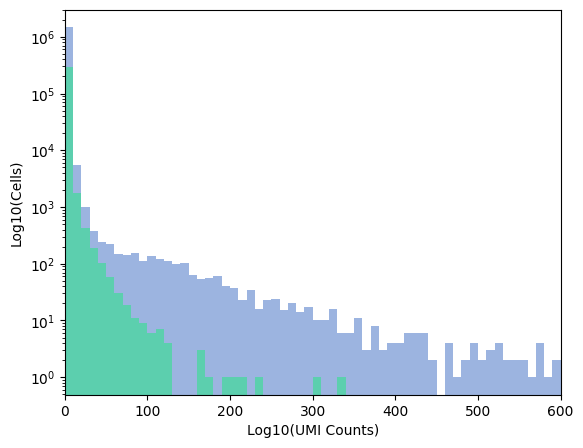

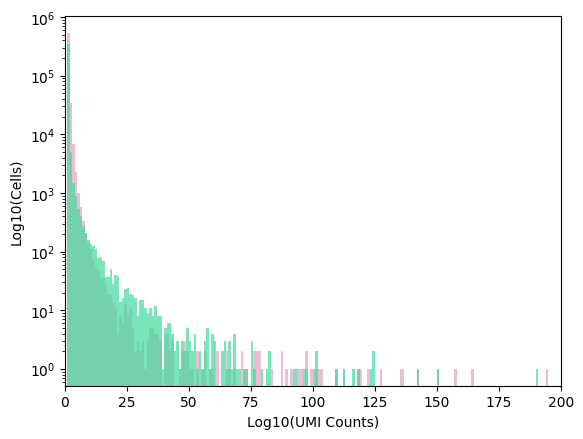

In [52]:
#Zoomed for inset figure panels
#Cells first
plt.figure().set_figheight(5)

maximum=(cell_real['UMI_Count']).max()
plt.hist((cell_real['UMI_Count']),bins=np.arange(0, maximum + .05, 10),color='#7294d4',alpha=0.7)

maximum=(cell_empty['UMI_Count']).max()
plt.hist((cell_empty['UMI_Count']),bins=np.arange(0, maximum + .05, 10),color='#42DB9A',alpha=0.7)

plt.xlabel('Log10(UMI Counts)')
plt.ylabel('Log10(Cells)')
plt.xlim([-.1, 600])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/zoomed_cell_combo_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()


#Then nuc
maximum=(nuc_real['UMI_Count']).max()
plt.hist((nuc_real['UMI_Count']),bins=np.arange(0, maximum + .05, 1),color='#e6a0c4',alpha=0.7)
maximum=(nuc_empty['UMI_Count']).max()
plt.hist((nuc_empty['UMI_Count']),bins=np.arange(0, maximum + .05, 1),color='#42DB9A',alpha=0.7)

plt.xlabel('Log10(UMI Counts)')
plt.ylabel('Log10(Cells)')
plt.xlim([-.1, 200])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/zoomed_nuc_combo_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

##### Summed transcripts

In [50]:
summed_nuc_empty

,UMI_Count
CBC,
n1_AAAAAAAAAAGGATCC,1
n1_AAAAAAAAACATACGG,1
n1_AAAAAAAAAGTAATGC,1
n1_AAAAAAAAAGTACATG,1
n1_AAAAAAAAAGTCACGT,1
...,...
n4_CCTTCCTAACAACATA,1
n4_CCTTCCTACATACCAG,4
n4_CCTTCCTCAATCCCAT,1


In [46]:
#Make UMI count-summed dataframes
summed_nuc=pd.DataFrame(nuc_real.groupby('CBC')['UMI_Count'].sum())
summed_cell=pd.DataFrame(cell_real.groupby('CBC')['UMI_Count'].sum())

summed_nuc_empty=pd.DataFrame(nuc_empty.groupby('CBC')['UMI_Count'].sum())
summed_cell_empty=pd.DataFrame(cell_empty.groupby('CBC')['UMI_Count'].sum())

nuc_dist = summed_nuc['UMI_Count']
cell_dist = summed_cell['UMI_Count']
empty_c_dist=summed_cell_empty['UMI_Count']
empty_n_dist=summed_nuc_empty['UMI_Count']

print('Nuc mean:')
print(nuc_dist.mean())
print('Nuc median:')
print(nuc_dist.median())
print('Nuc SEM:')
print(nuc_dist.sem())

print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print(cell_dist.median())
print('Cell SEM:')
print(cell_dist.sem())

print('Nuc, empty droplet mean:')
print(empty_n_dist.mean())
print('Nuc, empty droplet median:')
print(empty_n_dist.median())
print('Nuc, empty droplet SEM:')
print(empty_n_dist.sem())

print('Cell, empty droplet mean:')
print(empty_c_dist.mean())
print('Cell, empty droplet median:')
print(empty_c_dist.median())
print('Cell, empty droplet SEM:')
print(empty_c_dist.sem())

print('Wilcoxon Ranked Sum Results, nuclei:')
print(ranksums(nuc_dist, empty_n_dist))

print('Wilcoxon Ranked Sum Results, cells:')
print(ranksums(cell_dist, empty_c_dist))

Nuc mean:
92.98167430237402
Nuc median:
79.0
Nuc SEM:
0.9848253750726746
Cell mean:
178.69241541976857
Cell median:
128.0
Cell SEM:
1.56492192720617
Nuc, empty droplet mean:
1.4400220495171228
Nuc, empty droplet median:
1.0
Nuc, empty droplet SEM:
0.004393441505559562
Cell, empty droplet mean:
1.9474019199663097
Cell, empty droplet median:
1.0
Cell, empty droplet SEM:
0.009919550318514148
Wilcoxon Ranked Sum Results, nuclei:
RanksumsResult(statistic=144.99735310676556, pvalue=0.0)
Wilcoxon Ranked Sum Results, cells:
RanksumsResult(statistic=195.42182984081165, pvalue=0.0)


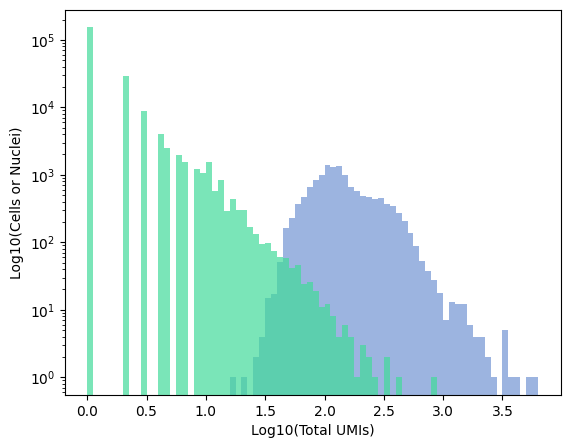

In [54]:
#Cells first
plt.figure().set_figheight(5)

maximum=np.log10(summed_cell['UMI_Count']).max()
plt.hist(np.log10(summed_cell['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#7294d4',alpha=0.7)

maximum=np.log10(summed_cell_empty['UMI_Count']).max()
plt.hist(np.log10(summed_cell_empty['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#42DB9A',alpha=0.7)


plt.xlabel('Log10(Total UMIs)')
plt.ylabel('Log10(Cells or Nuclei)')
#plt.xlim([-.1, 5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/cells_total_counts_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

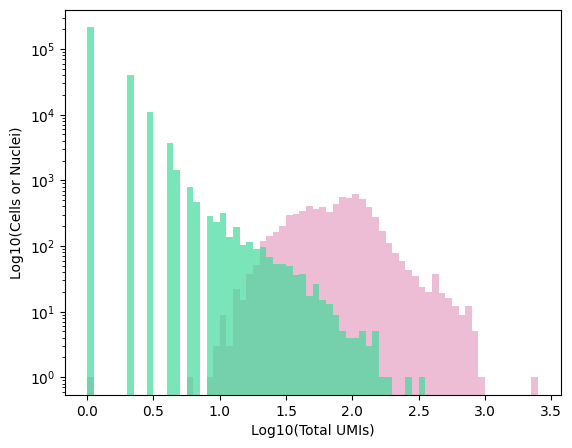

In [55]:
#Then nuc
plt.figure().set_figheight(5)

maximum=np.log10(summed_nuc['UMI_Count']).max()
plt.hist(np.log10(summed_nuc['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#e6a0c4',alpha=0.7)

maximum=np.log10(summed_nuc_empty['UMI_Count']).max()
plt.hist(np.log10(summed_nuc_empty['UMI_Count']),bins=np.arange(0, maximum + .05, .05),color='#42DB9A',alpha=0.7)


plt.xlabel('Log10(Total UMIs)')
plt.ylabel('Log10(Cells or Nuclei)')
#plt.xlim([-.1, 5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/nuc_total_counts_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

##### Unique barcodes

In [16]:
#Make unique barcode per cell/nuc dataframes
summed_nuc=pd.DataFrame(nuc_real.groupby('CBC')['barcode'].nunique())
summed_cell=pd.DataFrame(cell_real.groupby('CBC')['barcode'].nunique())

summed_nuc_empty=pd.DataFrame(nuc_empty.groupby('CBC')['barcode'].nunique())
summed_cell_empty=pd.DataFrame(cell_empty.groupby('CBC')['barcode'].nunique())

nuc_dist = summed_nuc['barcode']
cell_dist = summed_cell['barcode']
empty_c_dist=summed_cell_empty['barcode']
empty_n_dist=summed_nuc_empty['barcode']

print('Nuc mean:')
print(nuc_dist.mean())
print('Nuc median:')
print(nuc_dist.median())
print('Nuc SEM:')
print(nuc_dist.sem())

print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print(cell_dist.median())
print('Cell SEM:')
print(cell_dist.sem())

print('Nuc, empty droplet mean:')
print(empty_n_dist.mean())
print('Nuc, empty droplet median:')
print(empty_n_dist.median())
print('Nuc, empty droplet SEM:')
print(empty_n_dist.sem())

print('Cell, empty droplet mean:')
print(empty_c_dist.mean())
print('Cell, empty droplet median:')
print(empty_c_dist.median())
print('Cell, empty droplet SEM:')
print(empty_c_dist.sem())

print('Wilcoxon Ranked Sum Results, nuclei:')
print(ranksums(nuc_dist, empty_n_dist))

print('Wilcoxon Ranked Sum Results, cells:')
print(ranksums(cell_dist, empty_c_dist))

Nuc mean:
80.9086491739553
Nuc median:
71.0
Nuc SEM:
0.7358885341212925
Cell mean:
109.40686961008329
Cell median:
99.0
Cell SEM:
0.4173339248222315
Nuc, empty droplet mean:
1.2812183808836488
Nuc, empty droplet median:
1.0
Nuc, empty droplet SEM:
0.0014186581970851337
Cell, empty droplet mean:
1.4004364429896345
Cell, empty droplet median:
1.0
Cell, empty droplet SEM:
0.0034252688356272393
Wilcoxon Ranked Sum Results, nuclei:
RanksumsResult(statistic=145.0888417685669, pvalue=0.0)
Wilcoxon Ranked Sum Results, cells:
RanksumsResult(statistic=195.49236107641323, pvalue=0.0)


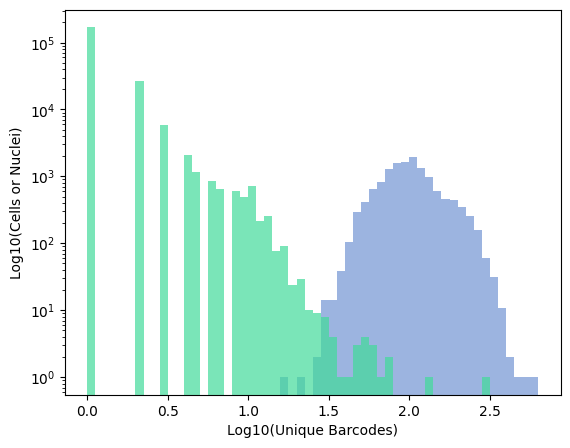

In [61]:
#Cells first
plt.figure().set_figheight(5)

maximum=np.log10(summed_cell['barcode']).max()
plt.hist(np.log10(summed_cell['barcode']),bins=np.arange(0, maximum + .05, .05),color='#7294d4',alpha=0.7)

maximum=np.log10(summed_cell_empty['barcode']).max()
plt.hist(np.log10(summed_cell_empty['barcode']),bins=np.arange(0, maximum + .05, .05),color='#42DB9A',alpha=0.7)


plt.xlabel('Log10(Unique Barcodes)')
plt.ylabel('Log10(Cells or Nuclei)')
#plt.xlim([-.1, 5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/cells_unique_barcodes_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

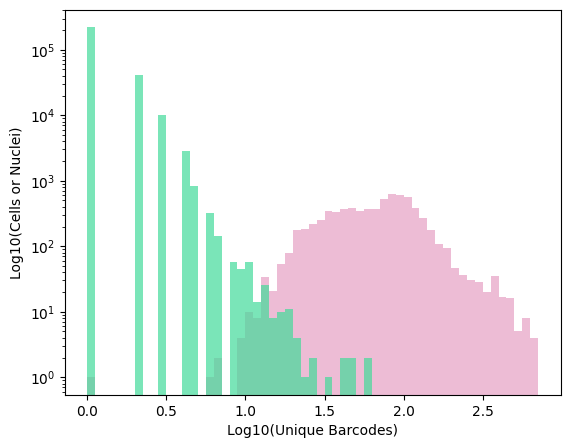

In [64]:
#Then nuc
plt.figure().set_figheight(5)

maximum=np.log10(summed_nuc['barcode']).max()
plt.hist(np.log10(summed_nuc['barcode']),bins=np.arange(0, maximum + .05, .05),color='#e6a0c4',alpha=0.7)

maximum=np.log10(summed_nuc_empty['barcode']).max()
plt.hist(np.log10(summed_nuc_empty['barcode']),bins=np.arange(0, maximum + .05, .05),color='#42DB9A',alpha=0.7)


plt.xlabel('Log10(Unique Barcodes)')
plt.ylabel('Log10(Cells or Nuclei)')
#plt.xlim([-.1, 5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/fig_7/nuc_unique_barcodes_dist.pdf', bbox_inches='tight', format='pdf')
plt.show()

##### Box and whisker plot

Format data for input into box and whisker plot

In [17]:
nuc_real['metric']='combo'
nuc_real['droplet_status']='real'

cell_real['metric']='combo'
cell_real['droplet_status']='real'

nuc_empty['metric']='combo'
nuc_empty['droplet_status']='empty'

cell_empty['metric']='combo'
cell_empty['droplet_status']='empty'

cell_empty = cell_empty.rename(columns={'UMI_Count': 'value'})
nuc_empty = nuc_empty.rename(columns={'UMI_Count': 'value'})
cell_real = cell_real.rename(columns={'UMI_Count': 'value'})
nuc_real = nuc_real.rename(columns={'UMI_Count': 'value'})

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_4657/3050788780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_real['metric']='combo'
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_4657/3050788780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_real['droplet_status']='real'
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_4657/3050788780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [18]:
summed_nuc=pd.DataFrame(nuc_real.groupby('CBC')['value'].sum())
summed_cell=pd.DataFrame(cell_real.groupby('CBC')['value'].sum())

summed_nuc_empty=pd.DataFrame(nuc_empty.groupby('CBC')['value'].sum())
summed_cell_empty=pd.DataFrame(cell_empty.groupby('CBC')['value'].sum())

summed_nuc['metric']='total'
summed_nuc['droplet_status']='real'

summed_cell['metric']='total'
summed_cell['droplet_status']='real'

summed_nuc_empty['metric']='total'
summed_nuc_empty['droplet_status']='empty'

summed_cell_empty['metric']='total'
summed_cell_empty['droplet_status']='empty'

In [19]:
unique_nuc=pd.DataFrame(nuc_real.groupby('CBC')['barcode'].nunique())
unique_cell=pd.DataFrame(cell_real.groupby('CBC')['barcode'].nunique())

unique_nuc_empty=pd.DataFrame(nuc_empty.groupby('CBC')['barcode'].nunique())
unique_cell_empty=pd.DataFrame(cell_empty.groupby('CBC')['barcode'].nunique())

unique_nuc['metric']='unique'
unique_nuc['droplet_status']='real'

unique_cell['metric']='unique'
unique_cell['droplet_status']='real'

unique_nuc_empty['metric']='unique'
unique_nuc_empty['droplet_status']='empty'

unique_cell_empty['metric']='unique'
unique_cell_empty['droplet_status']='empty'


unique_cell_empty = unique_cell_empty.rename(columns={'barcode': 'value'})
unique_nuc_empty = unique_nuc_empty.rename(columns={'barcode': 'value'})
unique_cell = unique_cell.rename(columns={'barcode': 'value'})
unique_nuc = unique_nuc.rename(columns={'barcode': 'value'})

unique_nuc['CBC']=unique_nuc.index
unique_cell['CBC']=unique_cell.index
unique_nuc_empty['CBC']=unique_nuc_empty.index
unique_cell_empty['CBC']=unique_cell_empty.index
unique_cell_empty

,value,metric,droplet_status,CBC
CBC,,,,
c1_AAAAAAAAAAATATTG,1,unique,empty,c1_AAAAAAAAAAATATTG
c1_AAAAAAAAAAGGATCG,1,unique,empty,c1_AAAAAAAAAAGGATCG
c1_AAAAAAAAAATAAATT,2,unique,empty,c1_AAAAAAAAAATAAATT
c1_AAAAAAAAAGAAAAAT,1,unique,empty,c1_AAAAAAAAAGAAAAAT
c1_AAAAAAAAAGTACACA,1,unique,empty,c1_AAAAAAAAAGTACACA
...,...,...,...,...
c4_CCTTCCTGCCGAAGTA,1,unique,empty,c4_CCTTCCTGCCGAAGTA
c4_CCTTCCTTAAACCAAC,1,unique,empty,c4_CCTTCCTTAAACCAAC
c4_CCTTCCTTAAACCCCT,1,unique,empty,c4_CCTTCCTTAAACCCCT


In [20]:
#Concatenate all dataframes together
cell_box_input=pd.concat([cell_empty,summed_cell_empty,unique_cell_empty,
                     cell_real,summed_cell,unique_cell])
nuc_box_input=pd.concat([nuc_empty,summed_nuc_empty,unique_nuc_empty,
                     nuc_real,summed_nuc,unique_nuc])

In [21]:
#Log10 standardize value column
cell_box_input['log_value']=np.log10(cell_box_input['value'])
nuc_box_input['log_value']=np.log10(nuc_box_input['value'])

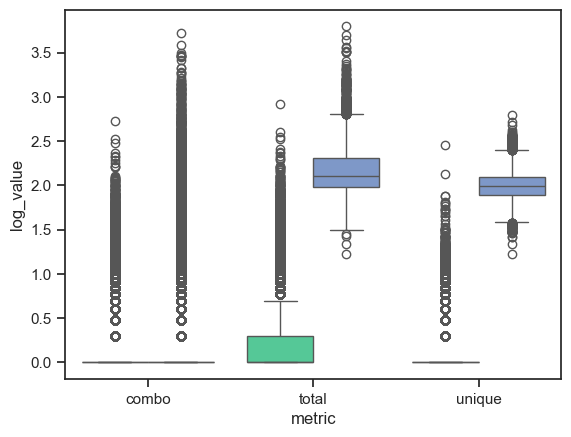

In [97]:
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=True, rc=custom_params)
palette = ["#42DB9A","#7294d4"]
sns.set_palette(palette)
sns.boxplot(data=cell_box_input, x="metric", y="log_value", hue="droplet_status")
plt.legend([],[], frameon=False)
plt.savefig('../figs/fig_7/cell_box.png', bbox_inches='tight', format='png')

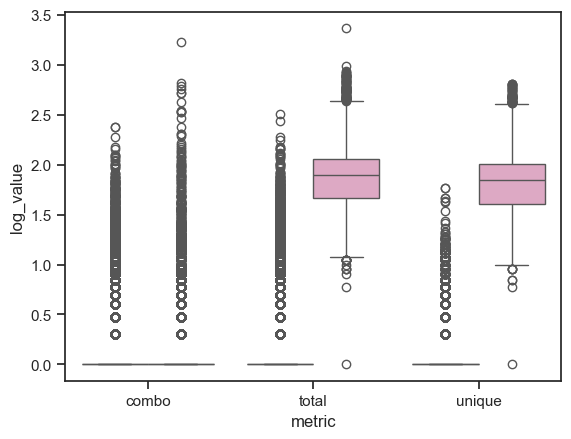

In [95]:
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(context='notebook', style='ticks', palette='deep', font='arial', font_scale=1, color_codes=True, rc=custom_params)
palette = ["#42DB9A","#e6a0c4"]
sns.set_palette(palette)
sns.boxplot(data=nuc_box_input, x="metric", y="log_value", hue="droplet_status")
plt.legend([],[], frameon=False)
plt.savefig('../figs/fig_7/nuc_box.png', bbox_inches='tight', format='png')

In [102]:
#Summary stats
from scipy.stats import ranksums
#print('This doesn't have built in test for multiple comparisons! Multiply by 3 for p-value on whole figure')
print('Nuc datasets')
print('Combos')
print(ranksums(np.log10(nuc_empty['value']), np.log10(nuc_real['value'])))

print('Totals')
print(ranksums(np.log10(summed_nuc_empty['value']), np.log10(summed_nuc['value'])))

print('Unique')
print(ranksums(np.log10(unique_nuc_empty['value']), np.log10(unique_nuc['value'])))

print('Cell datasets')
print('Combos')
print('Combos')
print(ranksums(np.log10(cell_empty['value']), np.log10(cell_real['value'])))

print('Totals')
print(ranksums(np.log10(summed_cell_empty['value']), np.log10(summed_cell['value'])))

print('Unique')
print(ranksums(np.log10(unique_cell_empty['value']), np.log10(unique_cell['value'])))

Nuc datasets
Combos
RanksumsResult(statistic=-40.8253823262088, pvalue=0.0)
Totals
RanksumsResult(statistic=-144.99735310676556, pvalue=0.0)
Unique
RanksumsResult(statistic=-145.0888417685669, pvalue=0.0)
Cell datasets
Combos
Combos
RanksumsResult(statistic=-59.19913438548862, pvalue=0.0)
Totals
RanksumsResult(statistic=-195.42182984081165, pvalue=0.0)
Unique
RanksumsResult(statistic=-195.49236107641323, pvalue=0.0)


##### Stacked bar plot with retainment overlay

In [ ]:
For each UMI threshold, need to calculate percentage of barcodes in nuclei only, empty droplets only, or overlapping 

And also calculate what percentage of barcodes, nuclei, and empty droplets are retained

In [10]:
def threshold_stats(real_dataset, #real dataset with list of barcodes and number of UMIs
                    empty_dataset, #empty droplets with list of barcodes and number of UMIs
                    umi #array of UMIs to threshold on
                   ):

    percent_empty=[]
    percent_real=[]
    percent_barcode=[]
    overlap_bcs=[]
    real_bcs=[]
    empty_bcs=[]
    
    for i in umi:


        
        print('Number of empty droplets pre-filtering:')
        print(empty_dataset['CBC'].nunique())
        print('Number of real cells/nuc pre-filtering:')
        print(real_dataset['CBC'].nunique())
        temp_real=real_dataset.copy(deep=True)
        temp_empty=empty_dataset.copy(deep=True)
    
        temp_empty.drop(temp_empty[temp_empty['value'] < umi].index, inplace=True)
        temp_real.drop(temp_real[temp_real['value'] < umi].index, inplace=True)

        print('Percentage of empty droplets remaining post-filtering:')
        print(temp_empty['CBC'].nunique()/empty_dataset['CBC'].nunique()*100)
        print()
        print('Percentage of real cells/nuc remaining post-filtering:')
        print(temp_real['CBC'].nunique()/real_dataset['CBC'].nunique()*100)
        print()
        print('Percentage of barcodes retained for analysis:')
        print(temp_real['CBC'].nunique()/real_dataset['barcode'].nunique()*100)
        print()

        total_bcs=pd.concat([temp_real,temp_empty])
        total_bcs['barcode'].nunique()
    
        print('Percent of barcodes overlapping in real cells/nuclei and empty droplets:')
        overlap=len(set(temp_real['barcode'])&set(temp_empty['barcode']))
        print(overlap/total_bcs['barcode'].nunique()*100)
        print()
    
        print('Percent of barcodes only found in real droplets:')
        print((temp_real['barcode'].nunique()-overlap)/total_bcs['barcode'].nunique()*100)
        print()

    
        print('Percent of barcodes found in only real cells/nuclei:')
        print((temp_empty['barcode'].nunique()-overlap)/total_bcs['barcode'].nunique()*100)
        print()

    

    return barplot_input

In [11]:
def threshold_stats(real_dataset, #real dataset with list of barcodes and number of UMIs
                    empty_dataset, #empty droplets with list of barcodes and number of UMIs
                    umi #array of UMIs to threshold on
                   ):

    percent_empty=[]
    percent_real=[]
    percent_barcode=[]
    overlap_bcs=[]
    real_bcs=[]
    empty_bcs=[]

    print('Number of empty droplets pre-filtering:')
    print(empty_dataset['CBC'].nunique())
    print('Number of real cells/nuc pre-filtering:')
    print(real_dataset['CBC'].nunique())
    
    for i in umi:
        

        temp_real=real_dataset.copy(deep=True)
        temp_empty=empty_dataset.copy(deep=True)
    
        temp_empty.drop(temp_empty[temp_empty['value'] < i].index, inplace=True)
        temp_real.drop(temp_real[temp_real['value'] < i].index, inplace=True)

        
        percent_empty.append(temp_empty['CBC'].nunique()/empty_dataset['CBC'].nunique()*100)
        percent_real.append(temp_real['CBC'].nunique()/real_dataset['CBC'].nunique()*100)
        percent_barcode.append(temp_real['barcode'].nunique()/real_dataset['barcode'].nunique()*100)

        total_bcs=pd.concat([temp_real,temp_empty])
        total_bcs['barcode'].nunique()
    
        overlap=len(set(temp_real['barcode'])&set(temp_empty['barcode']))
        overlap_bcs.append(overlap/total_bcs['barcode'].nunique()*100)

        real_bcs.append((temp_real['barcode'].nunique()-overlap)/total_bcs['barcode'].nunique()*100)

        empty_bcs.append((temp_empty['barcode'].nunique()-overlap)/total_bcs['barcode'].nunique()*100)
    
    barplot_input = pd.DataFrame(list(zip(umi, percent_empty, percent_real,percent_barcode,overlap_bcs,real_bcs,empty_bcs)),
                      columns =['umi','%empty', '%real','%bcs','overlap_bcs','real_bcs','empty_bcs'])

    return barplot_input

Visualization

In [22]:
barplot_input=threshold_stats(nuc_real,
                nuc_empty,
                [1,2,3,4,5,10,100])

barplot_input

Number of empty droplets pre-filtering:
275743
Number of real cells/nuc pre-filtering:
7203


,umi,%empty,%real,%bcs,overlap_bcs,real_bcs,empty_bcs
0,1,100.000000,100.000000,100.000000,38.840160,8.520240,52.639601
1,2,3.333901,94.821602,31.124783,8.493962,48.780771,42.725267
2,3,1.682001,63.723449,15.655466,2.758402,49.682942,47.558656
3,4,1.217075,38.747744,9.124468,1.867354,44.687701,53.444945
4,5,0.926225,26.502846,6.259662,1.515152,42.050944,56.433904
5,10,0.400010,7.663474,1.719514,0.839329,31.834532,67.326139
6,100,0.005440,0.388727,0.091497,2.325581,65.116279,32.558140


In [164]:
bars=barplot_input[['umi','real_bcs','overlap_bcs','empty_bcs']]
dots=barplot_input[['umi','%empty','%real','%bcs']]

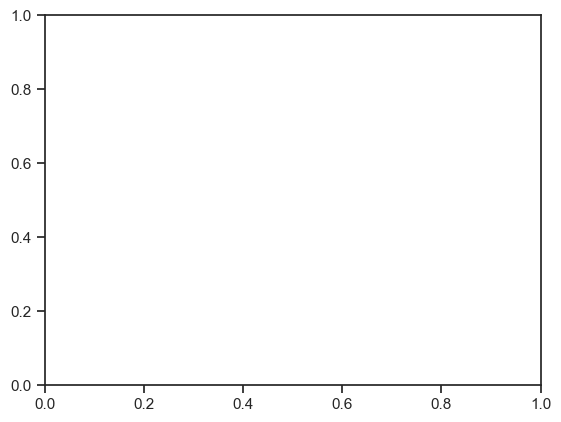

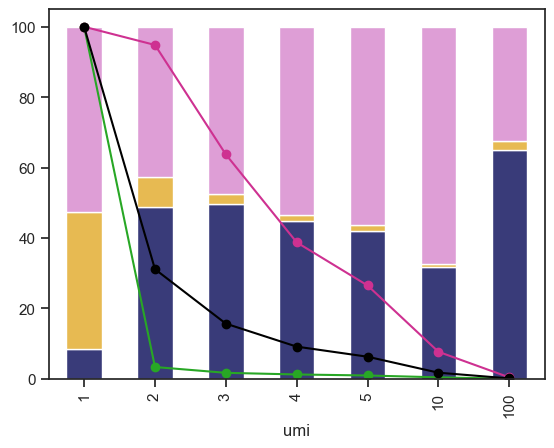

In [165]:
fig, ax = plt.subplots()

bars.plot(x='umi', 
                 kind='bar', 
                 stacked=True,
                 title='',
                 legend=False,
                 colormap='tab20b'
                )

plt.plot(dots.index,dots['%empty'], 'o-',color='#28a725')
plt.plot(dots.index,dots['%real'], 'o-',color='#ce3191')
plt.plot(dots.index,dots['%bcs'], 'o-',color='black')

plt.savefig('../figs/fig_7/nuc_bar_plot.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [23]:
barplot_input=threshold_stats(cell_real,
                cell_empty,
                [1,2,3,4,5,10,100])
barplot_input

Number of empty droplets pre-filtering:
208962
Number of real cells/nuc pre-filtering:
13567


,umi,%empty,%real,%bcs,overlap_bcs,real_bcs,empty_bcs
0,1,100.000000,100.000000,100.000000,36.034282,17.366307,46.599411
1,2,12.691303,99.454559,29.974160,25.761600,28.604905,45.633495
2,3,7.045300,90.970738,19.916738,20.854922,32.002438,47.142639
3,4,4.745360,78.020196,15.963250,17.409184,37.031235,45.559581
4,5,3.468573,65.629837,13.982199,15.214058,42.221960,42.563982
5,10,1.192561,34.517579,10.215332,10.188445,63.491406,26.320149
6,100,0.013400,9.021891,3.611829,0.234192,97.970336,1.795472


In [161]:
bars=barplot_input[['umi','real_bcs','overlap_bcs','empty_bcs']]
dots=barplot_input[['umi','%empty','%real','%bcs']]

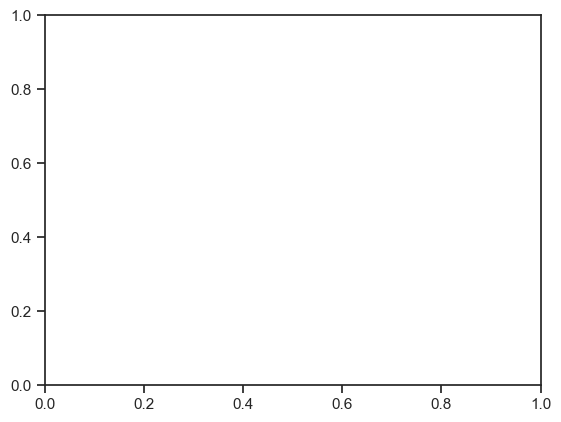

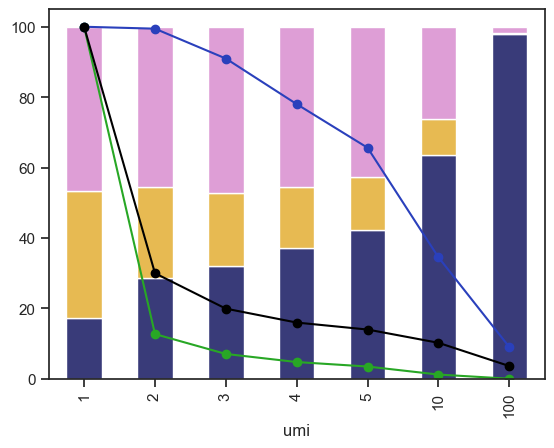

In [162]:
fig, ax = plt.subplots()

bars.plot(x='umi', 
                 kind='bar', 
                 stacked=True,
                 title='',
                 legend=False,
                 colormap='tab20b'
                )

plt.plot(dots.index,dots['%empty'], 'o-',color='#28a725')
plt.plot(dots.index,dots['%real'], 'o-',color='#2A40BC')
plt.plot(dots.index,dots['%bcs'], 'o-',color='black')

plt.savefig('../figs/fig_7/cell_bar_plot.pdf', bbox_inches='tight', format='pdf')
plt.show()